<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
# Check GPU assigned
!nvidia-smi

Wed Jul  7 09:56:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Network, dataset, functions and parameters

### LIBRARIES

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix

### Resnet32

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""

import math
from torch.nn import init
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.stride = stride
        self.use_relu = use_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.use_relu:
            out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Downsample(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(Downsample, self).__init__()
        assert stride == 2
        self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.avg(x)
        return torch.cat((x, x.mul(0)), 1)


class CifarResNet(nn.Module):

    def __init__(self, block=BasicBlock, depth=32, num_classes=0, channels=3):

        super(CifarResNet, self).__init__()

        # Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
        assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
        layer_blocks = (depth - 2) // 6
        bn = nn.BatchNorm2d
        self.inplanes = 16

        self.conv_1_3x3 = nn.Conv2d(channels, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_1 = bn(self.inplanes)

        self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
        self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
        self.stage_3 = self._make_layer(block, 64, layer_blocks, 2, last=True)
        self.avgpool = nn.AvgPool2d(8)
        self.relu = nn.ReLU()
        #self.linear = nn.Linear(64, num_classes)
        self.fcs = nn.ModuleList([nn.Linear(64, num_classes)])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, math.sqrt(1. / 64.))
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, last=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = Downsample(self.
inplanes, planes * block.expansion, stride)

        layers = [block(self.inplanes, planes, stride, downsample)]

        self.inplanes = planes * block.expansion

        if last:
            for i in range(1, blocks - 1):
                layers.append(block(self.inplanes, planes))

            layers.append(block(self.inplanes, planes, use_relu=False))

        else:
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv_1_3x3(x)

        x = self.bn_1(x)
        x = self.relu(x)

        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

    def predict(self, x):
        out = []
        for fc in self.fcs:
            out.append(fc(x))
        out = torch.cat(out, dim=1)
        return out

    def addOutputNodes(self, num_classes):
        self.fcs.append(nn.Linear(64, num_classes))

### Cifar100

In [4]:
# ref:
# https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
# https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10
# homework2 (caltech)

from torchvision.datasets import VisionDataset
from PIL import Image

import os
import os.path
import numpy as np
import pandas as pd
import pickle
import random

from torch.autograd import Variable

# This is an handler class for the Cifar dataset
class CIFAR100(VisionDataset):
    """
    `CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR100` Dataset.
    """
    base_folder = 'cifar-100-python'
    train_file = 'train'
    test_file = 'test'
    meta_file = 'meta'

    def __init__(self, root, split = 'train', transform = None):
        """
          Args:
              root (string): Root directory of the dataset where directory
                  cifar-100-python exists.
              split (string, optional): If 'train', creates dataset from training
                  set, otherwise creates from test set.
              transform (callable, optional): A function/transform that takes in a
                  PIL image and returns a transformed version.
        """
        super(CIFAR100, self).__init__(root, transform=transform)

        self.split = split
        if split == 'train':
            filename = self.train_file
        else:
            filename = self.test_file

        data_path = os.path.join(self.root, self.base_folder, filename)
        data = None
        labels = None

        with open(data_path, 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            data = entry['data']
            labels = entry['fine_labels']
        
        data = np.vstack(data).reshape(-1, 3, 32, 32)
        data = data.transpose((0, 2, 3, 1))  # Convert to HWC
        
        labels = np.array(labels)

        self.df = pd.DataFrame()
        self.df['data'] = pd.Series(list(data))
        self.df['labels'] = labels

        self.data = self.df['data']
        self.labels = self.df['labels']

        self._load_meta()

    def _load_meta(self):
        meta_path = os.path.join(self.root, self.base_folder, self.meta_file)
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
            self.label_names = meta['fine_label_names']

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.df.loc[index, 'data'], self.df.loc[index, 'labels']

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img) # Return a PIL image

        if self.transform is not None:
            img = self.transform(img)

        return index, img, target
    def __len__(self):
        return len(self.data)


    def getTargets(self):
        return set(self.labels)
     
    # test
    def get_indices(self, labels):
        return list(self.df[self.df['labels'].isin(labels)].index)

    def split_classes(self, n_splits=10, seed=None, dictionary_of='dataframes'):
        if dictionary_of not in ['dataframes','indices']:
            raise ValueError("'dictionary_of' must be equal to 'dataframes' or 'indices'")

        all_classes = list(self.df['labels'].value_counts().index)
        dictionary = {}
        random.seed(seed)
        random.shuffle(all_classes)
        split_size = int(len(all_classes)/n_splits)
        for j in range(n_splits):
            if ((j+1)*split_size < len(all_classes)):
                split_end = (j+1)*split_size
            else:
                split_end = None
            subgroup = all_classes[j*split_size:split_end]
            if dictionary_of == 'dataframes':
                dictionary[j] = self.df[self.df['labels'].isin(subgroup)]
            elif dictionary_of == 'indices':
                dictionary[j] = list(self.df[self.df['labels'].isin(subgroup)].index)
        return dictionary

    def split_groups_in_train_validation(self, groups, ratio=0.5, seed=None):
        groups_train_val = dict()
        for k, subdf in groups.items():
            train_indexes = []
            val_indexes = []
            split_labels = list(subdf['labels'].value_counts().index)
            for l in split_labels:
                indexes_to_sample = list(subdf[subdf['labels'] == l].index)
                random.seed(seed)
                train_samples = random.sample(indexes_to_sample, int(len(indexes_to_sample)*ratio))
                train_indexes = train_indexes + train_samples
                val_indexes = val_indexes + list(set(indexes_to_sample).difference(set(train_samples)))
            groups_train_val[k] = {
                'train': train_indexes,
                'val': val_indexes
            }
        return groups_train_val
    
    def split_in_train_val_groups(self, n_splits=10, ratio=0.5, seed=None):
        groups = self.split_classes(n_splits=n_splits, seed=seed)
        return self.split_groups_in_train_validation(groups, ratio=ratio, seed=seed)

    # given a tensors returns an image (used in exemplars)
    #def tensorToImg(self, tensor):
    #   return Variable(transform(Image.fromarray(img)), volatile=True)


### Reverse Index

In [5]:
import pandas as pd
import numpy as np
import torch

__all__ = ['ReverseIndex']

class ReverseIndex():

    def __init__(self, dataset, splits, device='cuda'):

        self.df = pd.DataFrame(columns=['group', 'labels'])

        for k in splits.keys():
            labels = list(dataset.df.loc[splits[k]['train'],'labels'].value_counts().index)
            group = [k for i in range(len(labels))]
            data = pd.DataFrame(np.array([group, labels]).T, columns=['group', 'labels'])
            self.df = self.df.append(data, ignore_index=True)

        self.df['nodes'] = self.df.index
        self.device = device
    
    def _changeIndex(self, reverse_index, column):
        reverse_index = reverse_index.set_index(column)
        reverse_index[column] = reverse_index.index
        return reverse_index

    def getLabels(self, outputs):
        outs = outputs.cpu().numpy()
        reverse_index = self._changeIndex(self.df, 'nodes')
        labels = reverse_index.loc[outs, 'labels']

        labels = torch.tensor(list(labels))
        return labels.to(self.device)

    def getNodes(self, labels):
        labels = labels.cpu().numpy()
       
        reverse_index = self._changeIndex(self.df, 'labels')

        nodes = reverse_index.loc[labels, 'nodes']

        nodes = torch.tensor(list(nodes))
        return nodes.to(self.device)

    def getGroups(self, distinct=True):
        return self.df['group'].value_counts().index.sort_values()
    
    def getLabelsOfGroup(self, group):
        return self.df.loc[self.df['group'] == group, 'labels']

### utils

In [6]:
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader
import math
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import Module

# These are the default iCaRL hyper-parameters
def getHyperparams():
	dictHyperparams = {
		"LR": 2,
		"MOMENTUM": 0.9,
		"WEIGHT_DECAY": 1e-5,
		"NUM_EPOCHS": 70,
		"MILESTONES": [49, 63],
		"BATCH_SIZE": 128,
		"DEVICE": 'cuda',
		"GAMMA": 0.2,
		"SEED": 66, #use 30, 42, 16
		"LOG_FREQUENCY": 10,
		"NUM_CLASSES": 100
	}
	return dictHyperparams

def getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize):
	optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
	scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1) 
	return optimizer, scheduler

# the mean and the std have been found on the web as mean and std of cifar100
# alternative (realistic): compute mean and std for the dataset
def getTransformations():
	# Define transforms for training phase
	train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
	                                      transforms.Pad(4), # Add padding
	                                      transforms.RandomCrop(32),# Crops a random squares of the image
	                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	# Define transforms for the evaluation phase
	eval_transform = transforms.Compose([
	                                      transforms.ToTensor(),
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	return train_transform, eval_transform

# BCEWithLogits = Sigmoid + BCE, is the loss used in iCaRL
def getLossCriterion():
	criterion = nn.BCEWithLogitsLoss(reduction = 'mean') 
	return criterion

# CrossEntropyLoss 
def computeLoss(criterion, outputs, labels):
	return criterion(outputs, labels)
 
# Loss L2
def l2Loss (outputs, labels):
  criterion = nn.MSELoss()
  return criterion(outputs, labels)

# Loss L1
def l1Loss(outputs, labels):
  criterion = nn.L1Loss()
  return criterion(outputs, labels)

# support BCE
def _one_hot_encode(labels, n_classes, reverse_index, dtype=None, device='cuda'):
	batch_size = len(labels)
	enconded = torch.zeros(batch_size, n_classes, dtype=dtype, device=device)
	labels=map_to_outputs(labels, reverse_index)
	for i, l in enumerate(labels):
	  enconded[i, l] = 1
	return enconded

def map_to_outputs(labels, reverse_index):
	if reverse_index is None:
	  return labels
	if type(labels) == int:
	  return int(reverse_index.getNodes(torch.tensor([labels])))
	elif type(labels) == torch.Tensor:
		return reverse_index.getNodes(labels)


def plotAccuracyTrend(method, data_plot_line, seed):
	plt.figure(figsize=(20,7))
	accuracyDF=pd.DataFrame(data_plot_line, columns = ['Classes','Accuracy'])
	ax = sns.lineplot(x="Classes", y="Accuracy",data=accuracyDF, marker = 'o')
	ax.minorticks_on()
	ax.set_xticks(np.arange(10,110,10))
	ax.set_xlim(xmin=9, xmax=101)
	ax.set_ylim(ymin=0, ymax=1)
	plt.legend(['Accuracy {}'.format(method)])
	ax.grid(axis='y')
	plt.title("Accuracies against seen classes {} - seed: {}".format(method, seed))
	
	filename = "acc_{}_{}.jpg".format(method, seed) # ex. acc_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

def plotConfusionMatrix(method, confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix {} - seed: {}".format(method, seed))

	filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

# Write down the metrics (accuracy trand and confusion matrix)
# this method is a shortcut when perfoming multiple tests with different splits (random_seed)
# and allow us to plot on the same graph the data from multiple models (accuracy)
def writeMetrics(method, seed, accuracies, confusionMatrixData):
  data = {}
  data['accuracies'] = []
  data['cm'] = [] #cm line
  i = 0
  for classes_seen in range(10, 110, 10): #x axis on the plot
    data['accuracies'].append({classes_seen : accuracies[i]}) 
    i += 1

  i = 0
  for class_num in range(0,len(confusionMatrixData)): #rows of the cm
    data['cm'].append({class_num : confusionMatrixData[i].tolist()}) 
    i += 1
  
  # dump to file
  aus = method + '_' + str(seed)
  filename = 'data_{}.json'.format(aus)
  with open(filename, 'w') as f:
    json.dump(data, f)

def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)


# Functions
def addOutputs(net, num):
    net.addOutputNodes(num)

def getResNet32():
    net = CifarResNet()
    # net.fc = nn.Linear(net.fc.in_features, output_size) # embedded in the class

    criterion = getLossCriterion()
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return net, criterion, optimizer, scheduler

def addOutputs(net, num):
    net.addOutputNodes(num)

def getNet():
    return getResNet32()

def getSchedulerOptimizer(net):
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return optimizer, scheduler
def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

### DATA

In [7]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton
DATA_DIR = 'DATA' # here the dataset will be downloaded

if not os.path.isdir('./{}'.format("$DATA_DIR/cifar-100-python")):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz'

--2021-07-07 09:56:18--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  50.4MB/s    in 3.6s    

2021-07-07 09:56:22 (45.3 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists
mv: cannot move 'cifar-100-python' to 'DATA/cifar-100-python/cifar-100-python': Directory not empty


### HYPERPARAMETERS

In [8]:
DEVICE = 'cuda'
NUM_CLASSES = 100
BATCH_SIZE = 128 
LR = 0.1    
MOMENTUM = 0.9     
WEIGHT_DECAY = 1e-05
NUM_EPOCHS = 70
NUM_EPOCHS_FINETUNE = 50
GAMMA = 0.2
LOG_FREQUENCY = 10
MILESTONES = [49,63]
RANDOM_SEED = 66
THRESHOLD = 0.5

### Data preprocessing

In [9]:
train_transform, eval_transform = getTransformations()

### train & test

In [10]:
# Import dataset and apply transformations 
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# Check datasets length 
print(len(train_dataset))
print(len(test_dataset))

50000
10000


### SPLIT DATA IN CLASSES

In [11]:
def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [12]:
# TRAIN / VAL split
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)
print(outputs_labels_mapping.getGroups())

# TEST split
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


In [13]:
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

## Fine tuning

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            # if (group_id > 1):
            #   old_features = old_net.forward(images)
            #   old_outputs = old_net.predict(old_features)
            #   labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning fine tuning

In [ ]:
### Fine tuning
def sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    old_net = None
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    #confusion_matrix(all_labels_cm, all_preds_cm)

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets)

GROUP:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.7173749208450317
Train step - Step 10, Loss 0.31387636065483093
Train step - Step 20, Loss 0.2874338626861572
Train step - Step 30, Loss 0.2654590606689453
Train epoch - Accuracy: 0.318989898989899 Loss: 0.34560690457772725 Corrects: 1579
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.26789265871047974
Train step - Step 50, Loss 0.258944034576416
Train step - Step 60, Loss 0.2350231260061264
Train step - Step 70, Loss 0.23865528404712677
Train epoch - Accuracy: 0.44363636363636366 Loss: 0.24301170718790305 Corrects: 2196
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.23784291744232178
Train step - Step 90, Loss 0.22167158126831055
Train step - Step 100, Loss 0.22836807370185852
Train step - Step 110, Loss 0.21694694459438324
Train epoch - Accuracy: 0.48707070707070704 Loss: 0.22610946089330344 Corrects: 2411
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.21196965873241425
Train step - Step 130, Loss 0.20575585961341

KeyboardInterrupt: ignored

### plot results

In [ ]:
method = "finetuning"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

## LWF

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning LWF

In [ ]:
### LWF
def sequentialLearningLWF(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1


    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
# net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningLWF(train_subsets, val_subsets, test_subsets)

### plot results

In [ ]:
method = "Learning Without Forgetting"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

In [ ]:
"""num_classes_seen = 100
dif_accuracies=printAccuracyDifference(net,old_accuracies, num_classes_seen)
dif_accuracies"""

## iCaRL

### classify

In [14]:
def classify(batch_img, net, exemplar_sets):
  """ classify images by nearest mean-of-exemplars """ 
  """ 
  class1: list_of_indices for images that represent class1
  class2: list_of_indices for images that represent class2
  ...
  class100: list_of_indices for images that represent class 100
  with Subset I retrieve the images from the train_dataset
  iterate over it to calculate mean for each class
  """
  net.eval()
  classes_mean = []
  for k, exemplars_indices in exemplar_sets.items():
    features = []
    class_images_set = Subset(train_dataset, exemplars_indices)
    class_images = DataLoader(class_images_set, batch_size=BATCH_SIZE, num_workers=2)
    for _, images, labels in class_images:
      # for each class (paper from y=1...t) calculate features and then mean
      feature = net.forward(images)
      features.append(feature)
    features_s = torch.cat(features)
    class_mean = features_s.mean(0)
    classes_mean.append(class_mean)
    means_exemplars = torch.cat(classes_mean, dim=0)
    means_exemplars = torch.stack([means_exemplars] * BATCH_SIZE)
    means_exemplars = means_exemplars.transpose(1,2)
  feature_images_to_classify = net.forward(batch_img)
  # sono da normalizzare?
  feature_images_to_classify = feature_images_to_classify.unsqueeze(2)
  feature_images_to_classify = feature_images_to_classify.expand_as(means_exemplars) # expand_as to get the same dimension
  preds = torch.argmin((feature_images_to_classify - means_exemplars).pow(2).sum(1), dim=1)
  return preds

### construct exemplar set

In [15]:
import sys

def constructExemplarSet(net, Xclass, m):
#Xclass contiene immagini e label della classe X
  exemplars_set = []
  feature_exemplars = []
  indexes = []
  features = [] 
  class_images = []
  net.eval()
  
  with torch.no_grad():
    XtrainLoader = torch.utils.data.DataLoader(Xclass, shuffle = True, batch_size=1, num_workers=2)
    for _, image, labels in XtrainLoader:
      image = image.to(DEVICE)
      class_images.append(image)
      # per ogni immagine della classe x, prendiamo le rispettive feature e le uniamo nel vettore features, che contiene tutte quelle delle immagini della classe x
      feature = net.forward(image)
      #feature = net.predict(featuretmp)
      feature = feature/np.linalg.norm(feature.cpu())
      features.append(feature)

    features = torch.cat(features, dim=0) #cat solve the problem of inequal size of tensors 
    current_class_mean = features.mean(0) # mu = media delle features delle immagini della classe

    for k in range(1, m+1):
      min = 100000
      sum = 0
      for j in range(k-1):
        sum += feature_exemplars[j]
      for x in range(len(Xclass)): 
        if (x not in indexes):
          phiX = features[x]
          val = current_class_mean - ((phiX + sum)/k)
          val = np.linalg.norm(val.cpu().numpy()) ## NORMA 
          if (val < min):
            min = val
            feature_min = phiX
            index_min = x
      feature_exemplars.append(feature_min)
      exemplars_set.append(Xclass[index_min][0])

    print("lunghezza exemplar set: ", len(exemplars_set))
    return exemplars_set

### reduce exemplar set

In [16]:
# DA CHIAMARE PER OGNI CLASSE k: riduce il numero di exemplars all'interno dell'exemplar_set della classe k 
# EXEMPLAR SET è una lista di indici che rappresentano la posizione dell'immagine selezionata per l'exemplar della classe corrente nel dataset di partenza
def reduceExemplarSet(m, exemplars_set):
  exemplars_new = []
  for i in range(m):
    if (exemplars_set != []):
      exemplars_new.append(exemplars_set[i])

  return exemplars_new

### update representation

In [17]:
def updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes, group_id, K, exemplars_set_tot, old_net):
  #exemplars_set_tot contiene tutti gli exemplars set ottenuti fino ad ora
  #train_iter contiene tutti i dati (immagini + labels) delle classi nuove (s, .., t)
  exemplars_subset = []
  exemplars_indices = []
  total_exemplars = []
  labels_tot = []

  for k, exemplar_set_class_k in exemplars_set_tot.items():
    # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
    if (exemplar_set_class_k != []):
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])

  if group_id > 1:
    train_subset_total = torch.utils.data.ConcatDataset([train_subset, total_exemplars])
  else:
    train_subset_total = train_subset
    
  print("Len TOTAL train susbset: ", len(train_subset_total))
  train_loader = torch.utils.data.DataLoader(train_subset_total, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  # train_loader è la concatenazione delle nuove classi con gli exemplar_sets calcolati fino a questo punto 
  print("training")
  train(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)
  #trainWithOtherLosses(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)
  #trainCEandL1(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)

### incremental train

In [18]:
import copy
def incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_until_now):
  print("Starting the update representation")
  exemplar_indices = None
  num_classes = 10
  new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
  print("NEW CLASSES: ", new_classes_examined)

  updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net)
                
  iteration = group_id - 1
  t = (num_classes * iteration) + num_classes # num_classes ricevute fino a questo momento 
  m = int(K/t) #casto ad intero ? per difetto o eccesso?
  #s = num_classes * iteration

  # REDUCING EXEMPLAR SET FOR EXISTING CLASSES
  print("reducing exemplars for each class")
  print(total_classes_until_now)
  for y in total_classes_until_now: #ci serve un set con tutte le classi fino ad ora viste
    exemplar_y_new = reduceExemplarSet(m, exemplars_set_tot[y]) # valore associato alla chiave y che rappresenta il label della classe 
    print("REDUCED EXEMPLAR: ", len(exemplar_y_new))
    exemplars_set_tot[y] = exemplar_y_new

  
  # CONSTRUCTION EXEMPLAR SET FOR NEW CLASSES
  for y in new_classes_examined: # nuovi classi in arrivo di cui vogliamo costruire il set rappresentativo
    images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data']
    imgs_idxs = images_current_class.index # the indexes of all the images in the current classe being considered 0...49k
    class_train_subset = Subset(train_dataset, imgs_idxs)#subset of the train dataset where i have all the imgs of class y
    print("class train: ", class_train_subset)
    print("Constructing exemplars of class", y)
    exemplars_set = constructExemplarSet(net, class_train_subset, m) # exemplar set è un set di indici
    #devo recuperare dal dataset iniziale l'indice delle immagini dell'exemplar set creato 
    #for image in exemplars_set:
     # exemplars_set = train_dataset.df.index[train_dataset.df['data'] == image].tolist()
    exemplars_set_tot[y] = exemplars_set
    print("exemplar set: ", exemplars_set)

  # IMPLEMENTATION 'END-to-END Incremental Learning' PAPER
  balancedFinetune(net, group_id, exemplars_set_tot, NUM_EPOCHS_FINETUNE)

### training

In [19]:
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes_till_now, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    print("num classes till now: ", num_classes_till_now)
    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes_till_now, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
           
            outputs = net.predict(features)

            #if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

### Train con CE + L1Loss 

In [20]:
import copy
def trainCEandL1(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    distillation_loss = 0
    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)
            # Classification LOSS
            lr = 0.01
            classification_loss = nn.CrossEntropyLoss()(outputs, labels) # BCE

            # Distillation LOSS 
            if (group_id > 1):
               old_features = old_net.forward(images)
               old_outputs = old_net.predict(old_features)
               #labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)
               new_labels = torch.sigmoid(old_outputs)
               new_outputs = outputs[:, 0:num_classes_till_previous_step]
               lr = 1e-3
               distillation_loss = l1Loss(new_outputs, new_labels) # L2
               print(distillation_loss)

            loss = classification_loss + distillation_loss
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### Train con CE + KLDiv Loss

In [21]:
import copy
def trainWithOtherLosses(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    distillation_loss = 0
    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)
            # Classification LOSS
            classification_loss = nn.CrossEntropyLoss()(outputs, labels)

            # Distillation LOSS 
            if (group_id > 1):
               old_features = old_net.forward(images)
               old_outputs = old_net.predict(old_features)
               T = 2
               beta = 0.25
               distillation_loss = nn.KLDivLoss()(F.log_softmax(outputs[:, 0:num_classes_till_previous_step]/T, dim = 1), F.softmax(old_outputs.detach()/T, dim = 1)) * T * T * beta * num_classes_till_previous_step

            loss = classification_loss + distillation_loss
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### test and validate

In [22]:
def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        #_, preds = classify(images, )
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### Balanced Finetune

In [23]:
def data_augmentation_e2e(img, lab):
    """
        Realize the data augmentation in End-to-End paper
        Parameters
        ----------
        img: the original images, size = (n, c, w, h)
        lab: the original labels, size = (n)
        Returns
        ----------
        img_aug: the original images, size = (n * 12, c, w, h)
        lab_aug: the original labels, size = (n * 12)
    """
    
    shape = np.shape(img)
    # print("IMG is: ",img)
    # print(shape[0], 1, shape[1], shape[2], shape[3])
    img_aug = np.zeros((shape[0], 6, shape[1], shape[2], shape[3]))
    img_aug[:, 0, :, :, :] = img
    lab_aug = np.zeros((shape[0], 6))
    # print("IMG_AUG is: ", img_aug)

    for i in range(shape[0]):
        # np.random.seed(int(time.time()) % 1000)

        # convert image from tensor to numpy
        image=img.numpy()
        im = image[i]
      
        # # brightness
        brightness = (np.random.rand(1)-0.5)*2*63
        im_temp = im + brightness

        img_aug[i, 1] = im_temp


        # constrast
        constrast = (np.random.rand(1)-0.5)*2*0.8+1
        m0 = np.mean(im[0])
        m1 = np.mean(im[1])
        m2 = np.mean(im[2])
        im_temp = im
        im_temp[0] = (im_temp[0]-m0)*constrast + m0
        im_temp[1] = (im_temp[1]-m1)*constrast + m1
        im_temp[2] = (im_temp[2]-m2)*constrast + m2
        img_aug[i, 2] = im_temp

        # crop
        im_temp = img_aug[i, :3]
        for j in range(3):
            x_ = int(np.random.rand(1)*1000)%8
            y_ = int(np.random.rand(1)*1000)%8
            im_temp = np.zeros(shape=(shape[1], shape[2]+8, shape[3]+8))
            im_temp[:, 4:-4, 4:-4] = img_aug[i, j]
            img_aug[i, 3+j] = im_temp[:, x_:x_+shape[2], y_:y_+shape[3]]



        # mirror
        # for j in range(6):
        #     im_temp = img_aug[i, j]
        #     img_aug[i, 6 + j] = im_temp[:,-1::-1,:]

        lab_aug[i, :] = lab[i]

    # idx = np.where(img_aug>255)
    # img_aug[idx] = 255
    # idx = np.where(img_aug<0)
    # img_aug[idx] = 0

    img_aug = np.reshape(img_aug, newshape=(shape[0]*6, shape[1], shape[2], shape[3]))
    img_aug = np.array(img_aug, dtype=np.float64)
    lab_aug = np.reshape(lab_aug, newshape=(shape[0]*6))
    lab_aug = np.array(lab_aug, dtype=np.float64)
    return img_aug, lab_aug

In [24]:
def balancedFinetune(net, iteration, exemplars_set_tot, NUM_EPOCHS):
  num_classes_till_previous_step = iteration * 10 - 10
  num_classes = iteration * 10
  total_exemplars = []
  criterion = nn.BCEWithLogitsLoss()
  old_net = copy.deepcopy(net)
  old_net.eval()

  #if iteration > 1:
  for k, exemplar_set_class_k in exemplars_set_tot.items():
    if (exemplar_set_class_k != []):
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])
    
  reduced_train_loader = torch.utils.data.DataLoader(total_exemplars, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  # reduced train loader is the sets of all exemplars of new and old classes

  # finetune
  lrc = LR *0.05 # small learning rate for finetune
  print('current lr = %f' % (lrc))
  softmax = nn.Softmax(dim=-1).cuda()
  current_step = 0
  acc_finetune_train = []

  for epoch in range(NUM_EPOCHS_FINETUNE):
    running_corrects = 0
    running_loss = 0.0
    print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS_FINETUNE))
    for _, images, labels in reduced_train_loader:
      images, labels = data_augmentation_e2e(images,labels) 
      images = torch.from_numpy(images) 
      labels = torch.from_numpy(labels) 
    # reduced_train_loader contains the same number of images for both new classes and old classes
      images = images.to(DEVICE, dtype=torch.float32)
      labels = labels.to(DEVICE, dtype=torch.float32)

    # criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(net.parameters(), lr=lrc, momentum=MOMENTUM,
                                    weight_decay= WEIGHT_DECAY, nesterov=True)


      # print("Outside: input size", img.size(), "output_size", lab.size())
      features = net.forward(images)
      outputs = net.predict(features)

      # classification loss
      prob_cls = softmax(outputs)
      labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
      labels = outputs_labels_mapping.getNodes(labels)

    # distillation loss for all classes (maybe the author only distillates for novel classes)
      if iteration > 1:
        old_features = old_net.forward(images)
        old_outputs = old_net.predict(old_features)
        labels_enc[:, 0:num_classes_till_previous_step] = torch.sigmoid(old_outputs[:, 0:num_classes_till_previous_step])


      loss = computeLoss(criterion, outputs, labels_enc)

      _, preds = torch.max(outputs.data, 1)
          
    # Update Corrects & Loss
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss = running_loss / float(len(reduced_train_loader.dataset)*6)
      epoch_acc = running_corrects / float(len(reduced_train_loader.dataset)*6)
      
    print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))

### CLASSIFIERS

In [25]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

def classifierTrain(net, exemplars_set_tot):
  torch.no_grad()
  torch.cuda.empty_cache()

  X_train, y_train = [], []
  total_exemplars = []
  counter = 0

  for k, exemplar_set_class_k in exemplars_set_tot.items():
    # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
    if (exemplar_set_class_k != []):
      counter += 1
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])


  exemplar_sets = torch.utils.data.DataLoader(total_exemplars, shuffle = True, batch_size=1, num_workers=2)
  for _, exemplar, label in exemplar_sets:
    exemplar = exemplar.to(DEVICE)
    features = net.forward(exemplar)
    outputs = net.predict(features)
    outputs = outputs.squeeze()
    outputs.data = outputs.data / outputs.data.norm()
    X_train.append(outputs.cpu().detach().numpy())
    y_train.append(label)

  K_nn = math.ceil(2000/counter)
  model1 = LinearSVC()
  model2 = KNeighborsClassifier(n_neighbors = K_nn)
  print("x train: ", X_train[0])
  print("y_train: ", y_train)
  model = model2.fit(X_train, y_train)
  return model

In [26]:
def classifySVM_KNN(net, images, model):
  torch.no_grad()
  torch.cuda.empty_cache()

  X_pred = []
  images = images.to(DEVICE)
  features = net.forward(images)
  outputs = net.predict(features)

  for feature in outputs:
    feature = feature.squeeze()
    feature.data = feature.data / feature.data.norm()
    X_pred.append(feature.cpu().detach().numpy())

  preds = model.predict(X_pred)
  return torch.tensor(preds)

In [27]:
def validateSVM(net, val_dataloader, criterion, num_classes, model):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        #images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        preds = classifySVM_KNN(net, images, model)
        preds = preds.to(DEVICE)

        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def testSVM(net, test_dataloader, num_classes, model):
    acc, _, all_preds_cm, all_labels_cm = validateSVM(net, test_dataloader, None, num_classes, model)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### main

In [28]:
def sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 10
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

      print("TRAIN: ", len(train_subset))
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      print("TEST SET LENGHT: ", len(test_set))
      print("TEST CURRENT GROUP SET LENGHT: ", len(test_subset))
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      test_classes = list(test_dataset.df.loc[test_set.indices, 'labels'].value_counts().index)
      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TEST_SET CLASSES: ", test_classes)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen) # Train the network with 10 classes at a time

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

In [29]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TRAIN:  4950
TEST SET LENGHT:  1000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [67, 65, 59, 56, 49, 39, 22, 20, 18, 4]
TRAIN_SET CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
VALIDATION CLASSES:  [59, 56, 49, 39, 22, 20, 18, 4, 67, 65]
GROUP:  1
Starting the update representation
NEW CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
Len TOTAL train susbset:  4950
training
num classes till now:  10
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.7586106657981873
Train step - Step 10, Loss 0.30439433455467224
Train step - Step 20, Loss 0.3009668290615082
Train step - Step 30, Loss 0.27255502343177795
Train epoch - Accuracy: 0.2725252525252525 Loss: 0.3634068099416868 Corrects: 1349
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.243915393948555
Train step - Step 50, Loss 0.2507122755050659
Train step - Step 60, Loss 0.2574337422847748
Train step - Step 70, Loss 0.24681983888149261
Train epoch - Accuracy: 0.4090909090909091 Loss: 0.2539203481300913 Corrects: 2025
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.2331002801656723
Train step - Step 90, Loss 0.236083984375
Train step - Step 100, Loss 0.2242729216814041
Train step - Step 110, Loss 0.22879250347614288
Train epoch - Accuracy: 0.4812121212121212 Loss: 0.23024384696074207 Corrects: 2382
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.21990866959095
Train step - Step 130, Loss 0.21456484496593475
Train ste

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.8 0.10368277132511139
TEST GROUP:  0.784
TEST ALL:  0.784
TRAIN:  4950
TEST SET LENGHT:  2000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [82, 81, 7, 16, 18, 20, 21, 22, 34, 39, 47, 49, 56, 59, 65, 67, 68, 79, 80, 4]
TRAIN_SET CLASSES:  [79, 47, 7, 82, 34, 81, 21, 80, 68, 16]
VALIDATION CLASSES:  [47, 34, 21, 16, 82, 81, 80, 79, 7, 68]
GROUP:  2
Starting the update representation
NEW CLASSES:  [79, 47, 7, 82, 34, 81, 21, 80, 68, 16]
Len TOTAL train susbset:  6950
training
num classes till now:  20
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.6371297240257263
Train step - Step 10, Loss 0.23396754264831543
Train step - Step 20, Loss 0.22108104825019836
Train step - Step 30, Loss 0.17696289718151093
Train step - Step 40, Loss 0.18279656767845154
Train step - Step 50, Loss 0.1719575971364975
Train epoch - Accuracy: 0.2710791366906475 Loss: 0.22203104276880087 Corrects: 1884
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.15855954587459564
Train step - Step 70, Loss 0.15287040174007416
Train step - Step 80, Loss 0.15348570048809052
Train step - Step 90, Loss 0.14665475487709045
Train step - Step 100, Loss 0.16603527963161469
Train epoch - Accuracy: 0.3722302158273381 Loss: 0.15918699614006837 Corrects: 2587
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.1479906439781189
Train step - Step 120, Loss 0.1614740788936615
Train step - Step 130, Loss 0.1593627780675888
Train step - Step 140, Loss 0.14892934262752533
Train step - Step 150, Loss 0.13271693885326385
Train step - Ste

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.68 0.13402265310287476
TEST GROUP:  0.668
TEST ALL:  0.705
TRAIN:  4950
TEST SET LENGHT:  3000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [81, 79, 4, 10, 16, 18, 20, 22, 24, 32, 34, 56, 64, 68, 76, 80, 82, 90, 7, 21, 23, 39, 47, 49, 59, 61, 65, 67, 75, 0]
TRAIN_SET CLASSES:  [75, 23, 90, 10, 61, 76, 64, 32, 24, 0]
VALIDATION CLASSES:  [61, 32, 90, 24, 23, 76, 75, 10, 0, 64]
GROUP:  3
Starting the update representation
NEW CLASSES:  [75, 23, 90, 10, 61, 76, 64, 32, 24, 0]
Len TOTAL train susbset:  6950
training
num classes till now:  30
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.38324716687202454
Train step - Step 10, Loss 0.16655233502388
Train step - Step 20, Loss 0.1694132685661316
Train step - Step 30, Loss 0.14863178133964539
Train step - Step 40, Loss 0.14255289733409882
Train step - Step 50, Loss 0.13499441742897034
Train epoch - Accuracy: 0.28345323741007195 Loss: 0.17022445923132862 Corrects: 1970
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.13450779020786285
Train step - Step 70, Loss 0.13380900025367737
Train step - Step 80, Loss 0.13550600409507751
Train step - Step 90, Loss 0.13184824585914612
Train step - Step 100, Loss 0.13286587595939636
Train epoch - Accuracy: 0.3530935251798561 Loss: 0.13492522705373147 Corrects: 2454
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.14303778111934662
Train step - Step 120, Loss 0.13294589519500732
Train step - Step 130, Loss 0.12963394820690155
Train step - Step 140, Loss 0.14003045856952667
Train step - Step 150, Loss 0.12749534845352173
Train step - S

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.56 0.12090732902288437
TEST GROUP:  0.587
TEST ALL:  0.6433333333333333
TRAIN:  4950
TEST SET LENGHT:  4000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 95, 68, 64, 56, 42, 36, 34, 32, 30, 24, 22, 20, 18, 16, 10, 6, 4, 2, 72, 76, 80, 61, 83, 81, 79, 75, 67, 65, 63, 59, 82, 49, 47, 39, 23, 21, 7, 90, 0]
TRAIN_SET CLASSES:  [95, 83, 63, 42, 30, 6, 2, 97, 72, 36]
VALIDATION CLASSES:  [63, 42, 36, 97, 95, 30, 83, 72, 6, 2]
GROUP:  4
Starting the update representation
NEW CLASSES:  [95, 83, 63, 42, 30, 6, 2, 97, 72, 36]
Len TOTAL train susbset:  6930
training
num classes till now:  40
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.27104392647743225
Train step - Step 10, Loss 0.15608878433704376
Train step - Step 20, Loss 0.1412857323884964
Train step - Step 30, Loss 0.137394979596138
Train step - Step 40, Loss 0.13113842904567719
Train step - Step 50, Loss 0.132715106010437
Train epoch - Accuracy: 0.23116883116883116 Loss: 0.15121370451618926 Corrects: 1602
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.12849323451519012
Train step - Step 70, Loss 0.13137739896774292
Train step - Step 80, Loss 0.12553651630878448
Train step - Step 90, Loss 0.1266622394323349
Train step - Step 100, Loss 0.12371938675642014
Train epoch - Accuracy: 0.27936507936507937 Loss: 0.12686303927096798 Corrects: 1936
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.12536972761154175
Train step - Step 120, Loss 0.11982672661542892
Train step - Step 130, Loss 0.12111399322748184
Train step - Step 140, Loss 0.1267518252134323
Train step - Step 150, Loss 0.12251835316419601
Train step - Ste

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.48 0.09552721679210663
TEST GROUP:  0.427
TEST ALL:  0.563
TRAIN:  4950
TEST SET LENGHT:  5000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 80, 97, 93, 85, 81, 65, 61, 49, 21, 9, 96, 76, 83, 72, 68, 64, 56, 36, 32, 24, 20, 16, 4, 2, 6, 10, 18, 79, 75, 67, 63, 59, 55, 47, 39, 31, 23, 19, 7, 98, 94, 90, 82, 54, 42, 34, 30, 22, 0]
TRAIN_SET CLASSES:  [55, 31, 19, 98, 94, 54, 93, 85, 9, 96]
VALIDATION CLASSES:  [55, 54, 98, 96, 31, 94, 93, 85, 19, 9]
GROUP:  5
Starting the update representation
NEW CLASSES:  [55, 31, 19, 98, 94, 54, 93, 85, 9, 96]
Len TOTAL train susbset:  6950
training
num classes till now:  50
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.25998884439468384
Train step - Step 10, Loss 0.14335153996944427
Train step - Step 20, Loss 0.13750776648521423
Train step - Step 30, Loss 0.12334831058979034
Train step - Step 40, Loss 0.11664299666881561
Train step - Step 50, Loss 0.11873897165060043
Train epoch - Accuracy: 0.21136690647482015 Loss: 0.14173941593375994 Corrects: 1469
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.11721021682024002
Train step - Step 70, Loss 0.12059339880943298
Train step - Step 80, Loss 0.1090506911277771
Train step - Step 90, Loss 0.11778222769498825
Train step - Step 100, Loss 0.11852949857711792
Train epoch - Accuracy: 0.2880575539568345 Loss: 0.11772399028856978 Corrects: 2002
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11273353546857834
Train step - Step 120, Loss 0.12059475481510162
Train step - Step 130, Loss 0.11240719258785248
Train step - Step 140, Loss 0.11538445949554443
Train step - Step 150, Loss 0.11541826277971268
Train step 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.5 0.07491014897823334
TEST GROUP:  0.442
TEST ALL:  0.5128
TRAIN:  4950
TEST SET LENGHT:  6000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 95, 85, 81, 65, 61, 57, 49, 45, 21, 13, 9, 96, 88, 80, 76, 72, 68, 64, 60, 56, 40, 36, 32, 24, 20, 16, 8, 4, 93, 97, 2, 15, 83, 79, 75, 67, 63, 59, 55, 47, 39, 31, 23, 19, 7, 6, 98, 94, 90, 82, 54, 42, 34, 30, 22, 18, 14, 10, 0]
TRAIN_SET CLASSES:  [99, 15, 14, 57, 45, 13, 88, 60, 40, 8]
VALIDATION CLASSES:  [60, 57, 45, 40, 99, 88, 15, 14, 13, 8]
GROUP:  6
Starting the update representation
NEW CLASSES:  [99, 15, 14, 57, 45, 13, 88, 60, 40, 8]
Len TOTAL train susbset:  6950
training
num classes till now:  60
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.24906323850154877
Train step - Step 10, Loss 0.14063303172588348
Train step - Step 20, Loss 0.1245354562997818
Train step - Step 30, Loss 0.12189552932977676
Train step - Step 40, Loss 0.11266627907752991
Train step - Step 50, Loss 0.10884886234998703
Train epoch - Accuracy: 0.18172661870503598 Loss: 0.1334558697720226 Corrects: 1263
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.10786408931016922
Train step - Step 70, Loss 0.10790202021598816
Train step - Step 80, Loss 0.11162833869457245
Train step - Step 90, Loss 0.11202482879161835
Train step - Step 100, Loss 0.10935467481613159
Train epoch - Accuracy: 0.25050359712230214 Loss: 0.11082560828049406 Corrects: 1741
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.11221341788768768
Train step - Step 120, Loss 0.11099618673324585
Train step - Step 130, Loss 0.11059882491827011
Train step - Step 140, Loss 0.10896433144807816
Train step - Step 150, Loss 0.10804105550050735
Train step 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.44 0.07319577783346176
TEST GROUP:  0.493
TEST ALL:  0.4801666666666667
TRAIN:  4950
TEST SET LENGHT:  7000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 49, 96, 9, 13, 17, 21, 45, 53, 84, 57, 61, 65, 69, 81, 85, 88, 80, 95, 36, 4, 8, 16, 20, 24, 32, 40, 76, 52, 56, 60, 64, 68, 72, 93, 97, 2, 47, 19, 23, 27, 31, 35, 39, 55, 6, 59, 63, 67, 75, 79, 83, 15, 7, 98, 94, 90, 86, 82, 70, 54, 50, 42, 34, 30, 22, 18, 14, 10, 0]
TRAIN_SET CLASSES:  [35, 27, 86, 70, 50, 69, 53, 17, 84, 52]
VALIDATION CLASSES:  [53, 52, 50, 35, 27, 86, 84, 17, 70, 69]
GROUP:  7
Starting the update representation
NEW CLASSES:  [35, 27, 86, 70, 50, 69, 53, 17, 84, 52]
Len TOTAL train susbset:  6930
training
num classes till now:  70
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.22782158851623535
Train step - Step 10, Loss 0.1259160190820694
Train step - Step 20, Loss 0.11795017123222351
Train step - Step 30, Loss 0.10954466462135315
Train step - Step 40, Loss 0.10734477639198303
Train step - Step 50, Loss 0.10397682338953018
Train epoch - Accuracy: 0.15800865800865802 Loss: 0.12358277398786503 Corrects: 1095
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.10475577414035797
Train step - Step 70, Loss 0.10249276459217072
Train step - Step 80, Loss 0.1014714315533638
Train step - Step 90, Loss 0.09823089838027954
Train step - Step 100, Loss 0.09785713255405426
Train epoch - Accuracy: 0.258008658008658 Loss: 0.10161625203417149 Corrects: 1788
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.10083706676959991
Train step - Step 120, Loss 0.09877265244722366
Train step - Step 130, Loss 0.10033499449491501
Train step - Step 140, Loss 0.09950342774391174
Train step - Step 150, Loss 0.09740973263978958
Train step - 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.38 0.0686594694852829
TEST GROUP:  0.542
TEST ALL:  0.44971428571428573
TRAIN:  4950
TEST SET LENGHT:  8000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 95, 96, 9, 13, 17, 21, 29, 37, 45, 49, 53, 57, 61, 65, 69, 81, 85, 93, 88, 84, 80, 40, 4, 8, 16, 20, 24, 32, 36, 44, 76, 48, 52, 56, 60, 64, 68, 72, 97, 2, 6, 51, 23, 27, 31, 35, 39, 43, 47, 55, 15, 59, 63, 67, 71, 75, 79, 83, 19, 7, 10, 50, 14, 18, 22, 30, 34, 38, 42, 54, 98, 70, 74, 78, 82, 86, 90, 94, 0]
TRAIN_SET CLASSES:  [71, 51, 43, 78, 74, 38, 37, 29, 48, 44]
VALIDATION CLASSES:  [51, 48, 44, 43, 38, 37, 29, 78, 74, 71]
GROUP:  8
Starting the update representation
NEW CLASSES:  [71, 51, 43, 78, 74, 38, 37, 29, 48, 44]
Len TOTAL train susbset:  6910
training
num classes till now:  80
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.20989863574504852
Train step - Step 10, Loss 0.12072384357452393
Train step - Step 20, Loss 0.11568106710910797
Train step - Step 30, Loss 0.1037750169634819
Train step - Step 40, Loss 0.10997650772333145
Train step - Step 50, Loss 0.10690180212259293
Train epoch - Accuracy: 0.15904486251808972 Loss: 0.12166015881877905 Corrects: 1099
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.10776346176862717
Train step - Step 70, Loss 0.10497602075338364
Train step - Step 80, Loss 0.10152029991149902
Train step - Step 90, Loss 0.0986364409327507
Train step - Step 100, Loss 0.1011282429099083
Train epoch - Accuracy: 0.21837916063675833 Loss: 0.10317847158991653 Corrects: 1509
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.10152561962604523
Train step - Step 120, Loss 0.10110817104578018
Train step - Step 130, Loss 0.09707239270210266
Train step - Step 140, Loss 0.09982927143573761
Train step - Step 150, Loss 0.09776534140110016
Train step -

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.4 0.058390725404024124
TEST GROUP:  0.441
TEST ALL:  0.405
TRAIN:  4950
TEST SET LENGHT:  9000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 10, 26, 34, 42, 50, 58, 74, 82, 90, 98, 19, 27, 35, 43, 51, 59, 67, 75, 83, 99, 18, 2, 87, 97, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 9, 17, 41, 49, 57, 65, 81, 4, 12, 20, 28, 22, 30, 38, 46, 54, 70, 78, 86, 94, 7, 15, 23, 31, 39, 47, 55, 63, 71, 79, 14, 6, 93, 5, 36, 44, 52, 60, 68, 76, 84, 92, 13, 85, 21, 29, 37, 45, 53, 61, 69, 77, 0]
TRAIN_SET CLASSES:  [87, 58, 46, 26, 77, 41, 5, 92, 28, 12]
VALIDATION CLASSES:  [28, 58, 46, 41, 92, 26, 87, 77, 12, 5]
GROUP:  9
Starting the update representation
NEW CLASSES:  [87, 58, 46, 26, 77, 41, 5, 92, 28, 12]
Len TOTAL train susbset:  6950
training
num classes till now:  90
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.18130478262901306
Train step - Step 10, Loss 0.11776713281869888
Train step - Step 20, Loss 0.11492538452148438
Train step - Step 30, Loss 0.10959713160991669
Train step - Step 40, Loss 0.10494540631771088
Train step - Step 50, Loss 0.10141608119010925
Train epoch - Accuracy: 0.13079136690647483 Loss: 0.11701951498179126 Corrects: 909
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.10338050127029419
Train step - Step 70, Loss 0.10353871434926987
Train step - Step 80, Loss 0.09818354994058609
Train step - Step 90, Loss 0.09977463632822037
Train step - Step 100, Loss 0.0989948958158493
Train epoch - Accuracy: 0.1856115107913669 Loss: 0.1015333258633991 Corrects: 1290
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.0959215834736824
Train step - Step 120, Loss 0.10105542093515396
Train step - Step 130, Loss 0.10021035373210907
Train step - Step 140, Loss 0.09826795756816864
Train step - Step 150, Loss 0.09496381878852844
Train step - S

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.52 0.05520527437329292
TEST GROUP:  0.54
TEST ALL:  0.38266666666666665
TRAIN:  4950
TEST SET LENGHT:  10000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 82, 2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 90, 87, 98, 3, 11, 19, 27, 35, 43, 51, 59, 67, 97, 89, 81, 73, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 1, 9, 17, 25, 33, 41, 49, 57, 65, 75, 83, 91, 93, 14, 22, 30, 38, 46, 54, 62, 70, 78, 86, 94, 7, 15, 23, 31, 39, 47, 55, 63, 71, 79, 6, 85, 99, 77, 4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 5, 13, 21, 29, 37, 45, 53, 61, 69, 0]
TRAIN_SET CLASSES:  [91, 11, 3, 66, 62, 89, 73, 33, 25, 1]
VALIDATION CLASSES:  [62, 25, 33, 91, 89, 11, 73, 3, 66, 1]
GROUP:  10
Starting the update representation
NEW CLASSES:  [91, 11, 3, 66, 62, 89, 73, 33, 25, 1]
Len TOTAL train susbset:  6930
training
num classes till now:  100
Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.1527811586856842
Train step - Step 10, Loss 0.1131708100438118
Train step - Step 20, Loss 0.102824367582798
Train step - Step 30, Loss 0.10780378431081772
Train step - Step 40, Loss 0.0964813232421875
Train step - Step 50, Loss 0.098739393055439
Train epoch - Accuracy: 0.13261183261183263 Loss: 0.10795705199542671 Corrects: 919
Starting epoch 2/70, LR = [0.1]
Train step - Step 60, Loss 0.09968818724155426
Train step - Step 70, Loss 0.09971245378255844
Train step - Step 80, Loss 0.09621088951826096
Train step - Step 90, Loss 0.09510888904333115
Train step - Step 100, Loss 0.09520570188760757
Train epoch - Accuracy: 0.2072150072150072 Loss: 0.09600872630078727 Corrects: 1436
Starting epoch 3/70, LR = [0.1]
Train step - Step 110, Loss 0.0981699600815773
Train step - Step 120, Loss 0.09650906175374985
Train step - Step 130, Loss 0.0948498323559761
Train step - Step 140, Loss 0.09507478773593903
Train step - Step 150, Loss 0.09240857511758804
Train step - Step 16

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.52 0.04793258383870125
TEST GROUP:  0.482
TEST ALL:  0.3475


##CLOSED AND OPEN WORLD

In [ ]:
#Dataset divided into 2 halves, 50 for closed 50 for open (choose five different random division)
#1) closed world
#  1.1)without rejection -> standard incremental scenario (train and test using selected 10 classes) but with 50 classes
#      iter = 0 -> 10 or 20 (he does so in BDOC) classes ? ask Dario
#      next iters -> add 10 until 50
#      result expected -> equal to incremental 
#
#  1.2)with rejection -> same procedure of above but we implement a rejection technique that 
#      classify as unknown an object that doesn't belong to the classes seen in the training (for the alg follow BDOC)
#      result expected -> idealistic the model should not reject any of the object because we've tested the model with classes seen in the training
#
#2) open world
#    at each step -> test the model only on unknown samples (the second half of dataset)
#    
#    result expected -> idealist the model should reject all of the test objects

###download and dividing dataset

In [ ]:
# Import dataset and apply transformations 
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# Check datasets length 
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [ ]:
#closed and open world
splits_of_10 = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
#first 5 splits to closed world
closed_data = {k:splits_of_10[k] for k in range(5)}

#last 5 to open (removing the train val splits)
open = []
for k in range(5,10):
  for j in["train", "val"]:
    open += splits_of_10[k][j]

### Modified iCaRL for closed/open

In [ ]:
def updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes, group_id, K, exemplars_set_tot, old_net, rejection=False, closed=True):
  #exemplars_set_tot contiene tutti gli exemplars set ottenuti fino ad ora
  #train_iter contiene tutti i dati (immagini + labels) delle classi nuove (s, .., t)
  exemplars_subset = []
  exemplars_indices = []
  total_exemplars = []
  labels_tot = []

  for k, exemplar_set_class_k in exemplars_set_tot.items():
    # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
    if (exemplar_set_class_k != []):
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])

  if group_id > 1:
    train_subset_total = torch.utils.data.ConcatDataset([train_subset, total_exemplars])
  else:
    train_subset_total = train_subset
    
  print("Len TOTAL train susbset: ", len(train_subset_total))
  train_loader = torch.utils.data.DataLoader(train_subset_total, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  # train_loader è la concatenazione delle nuove classi con gli exemplar_sets calcolati fino a questo punto 
  print("training")
  train(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net, rejection = rejection, closed = closed)

In [ ]:
import copy
def incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_until_now, rejection=False, closed=True):
  print("Starting the update representation")
  exemplar_indices = None
  num_classes = 10
  new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
  print("NEW CLASSES: ", new_classes_examined)

  updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, rejection=rejection, closed=closed)
                
  iteration = group_id - 1
  t = (num_classes * iteration) + num_classes # num_classes ricevute fino a questo momento 
  m = int(K/t) #casto ad intero ? per difetto o eccesso?
  #s = num_classes * iteration

  # REDUCING EXEMPLAR SET FOR EXISTING CLASSES
  print("reducing exemplars for each class")
  print(total_classes_until_now)
  for y in total_classes_until_now: #ci serve un set con tutte le classi fino ad ora viste
    exemplar_y_new = reduceExemplarSet(m, exemplars_set_tot[y]) # valore associato alla chiave y che rappresenta il label della classe 
    print("REDUCED EXEMPLAR: ", len(exemplar_y_new))
    exemplars_set_tot[y] = exemplar_y_new

  
  # CONSTRUCTION EXEMPLAR SET FOR NEW CLASSES
  for y in new_classes_examined: # nuovi classi in arrivo di cui vogliamo costruire il set rappresentativo
    images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data']
    imgs_idxs = images_current_class.index # the indexes of all the images in the current classe being considered 0...49k
    class_train_subset = Subset(train_dataset, imgs_idxs)#subset of the train dataset where i have all the imgs of class y
    print("class train: ", class_train_subset)
    print("Constructing exemplars of class", y)
    exemplars_set = constructExemplarSet(net, class_train_subset, m) # exemplar set è un set di indici
    #devo recuperare dal dataset iniziale l'indice delle immagini dell'exemplar set creato 
    #for image in exemplars_set:
     # exemplars_set = train_dataset.df.index[train_dataset.df['data'] == image].tolist()
    exemplars_set_tot[y] = exemplars_set
    print("exemplar set: ", exemplars_set)

In [ ]:
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes_till_now, group_id, old_net, num_epochs=NUM_EPOCHS, rejection=False, closed=True, threshold=THRESHOLD):    

      
    num_classes_till_previous_step = group_id * 10 - 10
    print("num classes till now: ", num_classes_till_now)
    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    print(num_epochs)
    for epoch in range(num_epochs):
        
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        if rejection == True:
          n_sample_known = 0
          n_sample_unknown = 0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes_till_now, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            #if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            if rejection == True:
              prediction_batch = outputs.data.cpu().numpy()
              for i in range(len(prediction_batch)):
                current_softmax = softmax(prediction_batch[i])
                if max(current_softmax)>THRESHOLD:
                  n_sample_known += 1
                else:
                  n_sample_unknown += 1
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        if rejection == True:
          if closed == True:
            epoch_acc = n_sample_known / float(len(train_dataloader.dataset))
            numb = n_sample_known
          else:
            epoch_acc = n_sample_unknown / float(len(train_dataloader.dataset))
            numb = n_sample_unknown
        else:
          epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, numb))
    print('Training finished in {} seconds'.format(time.time() - start_time))

In [ ]:
def validate(net, val_dataloader, criterion, num_classes, rejection = False, closed = False):
    #counter for rejection part, known and unknown
    if rejection==True:
      n_sample_known = 0
      n_sample_unknown = 0
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)
            
        _, preds = torch.max(outputs.data, 1)
        if rejection == True:
          prediction_batch = outputs.data.cpu().numpy()
          print(len(prediction_batch))
          for i in range(len(prediction_batch)):
            current_softmax = softmax(prediction_batch[i])
            if max(current_softmax)>THRESHOLD:
              n_sample_known += 1
            else:
              n_sample_unknown += 1
        else:
          #_, preds = classify(images, )
          running_corrects += torch.sum(preds == labels.data).data.item()

          all_preds_cm.extend(preds.tolist())
          all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    if rejection == True:
      if closed == True:
        acc = n_sample_known / float(len(val_dataloader.dataset))
      else:
        acc = n_sample_unknown / float(len(val_dataloader.dataset))
    else:
      acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes, rejection = False, closed = True):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes, rejection, closed)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

In [ ]:
def sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets, rejection = False, closed = True):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 5
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

      print("TRAIN: ", len(train_subset))
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      print("TEST SET LENGHT: ", len(test_set))
      print("TEST CURRENT GROUP SET LENGHT: ", len(test_subset))
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      test_classes = list(test_dataset.df.loc[test_set.indices, 'labels'].value_counts().index)
      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TEST_SET CLASSES: ", test_classes)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen, rejection=rejection, closed=closed) # Train the network with 10 classes at a time

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen, rejection=rejection, closed=closed)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen, rejection=rejection, closed=closed)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm


### Closed World

In [ ]:
# Reverse indexing for closed and open world
outputs_labels_mapping = ReverseIndex(train_dataset, splits_of_10)
print(outputs_labels_mapping.getGroups())

# TEST split
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)
#above are 10 splits but I want 5 for closed and 5 for open
test_splits_closed = {i:test_splits[i] for i in range(5)}
test_splits_open = []
for i in range(5,10):
  test_splits_open += test_splits[i]

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


In [ ]:
df = pd.DataFrame()
for i in outputs_labels_mapping.getGroups():
  print(outputs_labels_mapping.getLabelsOfGroup(i))

0    67
1    59
2    39
3    22
4    18
5    65
6    49
7    56
8    20
9     4
Name: labels, dtype: object
10    79
11    47
12     7
13    82
14    34
15    81
16    21
17    80
18    68
19    16
Name: labels, dtype: object
20    75
21    23
22    90
23    10
24    61
25    76
26    64
27    32
28    24
29     0
Name: labels, dtype: object
30    95
31    83
32    63
33    42
34    30
35     6
36     2
37    97
38    72
39    36
Name: labels, dtype: object
40    55
41    31
42    19
43    98
44    94
45    54
46    93
47    85
48     9
49    96
Name: labels, dtype: object
50    99
51    15
52    14
53    57
54    45
55    13
56    88
57    60
58    40
59     8
Name: labels, dtype: object
60    35
61    27
62    86
63    70
64    50
65    69
66    53
67    17
68    84
69    52
Name: labels, dtype: object
70    71
71    51
72    43
73    78
74    74
75    38
76    37
77    29
78    48
79    44
Name: labels, dtype: object
80    87
81    58
82    46
83    26
84    77
85    41
86     5
87 

In [ ]:
train_subsets = []
val_subsets = []
test_subsets = []

for v in closed_data.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,5):
    v=test_splits_closed[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

In [ ]:
#for the test of open world
open_test = Subset(test_dataset, test_splits_open)

In [ ]:
targets_open = set()
for i in range(len(open_test.indices)):
  targets_open.add(test_dataset.__getitem__(open_test.indices[i])[2])

In [ ]:
targets_closed = set()
for k in test_splits_closed:
  for j in range(len(test_splits_closed[k])):
    targets_closed.add(test_dataset.__getitem__(test_splits_closed[k][j])[2])

In [ ]:
#verifing that there aren't objects of the same class
list(targets_closed.intersection(targets_open))

[]

### Closed world without rejection

In [ ]:
#without rejection
rejection = False
closed = True
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TRAIN:  4950


KeyboardInterrupt: ignored

In [ ]:
method = "Closed world without Rejection"
print("metrics ClosedWord for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,5):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

### Closed world with rejection

In [ ]:
# train closed world with rejection
rejection = True
closed = True
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets, rejection=rejection, closed=closed)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TRAIN:  4950
TEST SET LENGHT:  1000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [67, 65, 59, 56, 49, 39, 22, 20, 18, 4]
TRAIN_SET CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
VALIDATION CLASSES:  [59, 56, 49, 39, 22, 20, 18, 4, 67, 65]
GROUP:  1
Starting the update representation
NEW CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
Len TOTAL train susbset:  4950
training
num classes till now:  10
5
Starting epoch 1/5, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.6994286775588989
Train step - Step 10, Loss 0.30136817693710327
Train step - Step 20, Loss 0.2911085784435272
Train step - Step 30, Loss 0.26708194613456726
Train epoch - Accuracy: 0.14585858585858585 Loss: 0.35155493756135303 Corrects: 1489
Starting epoch 2/5, LR = [0.1]
Train step - Step 40, Loss 0.27089643478393555
Train step - Step 50, Loss 0.2680715024471283
Train step - Step 60, Loss 0.2523084878921509
Train step - Step 70, Loss 0.2466038018465042
Train epoch - Accuracy: 0.31555555555555553 Loss: 0.24956819676389597 Corrects: 2074
Starting epoch 3/5, LR = [0.1]
Train step - Step 80, Loss 0.2362622767686844
Train step - Step 90, Loss 0.24306665360927582
Train step - Step 100, Loss 0.23924599587917328
Train step - Step 110, Loss 0.1914578527212143
Train epoch - Accuracy: 0.4163636363636364 Loss: 0.23055763977946658 Corrects: 2346
Starting epoch 4/5, LR = [0.1]
Train step - Step 120, Loss 0.21142147481441498
Train step - Step 130, Loss 0.2643110156059265


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.56 0.2094002068042755
TEST GROUP:  0.612
TEST ALL:  0.508
TRAIN:  4950
TEST SET LENGHT:  2000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [82, 81, 7, 16, 18, 20, 21, 22, 34, 39, 47, 49, 56, 59, 65, 67, 68, 79, 80, 4]
TRAIN_SET CLASSES:  [79, 47, 7, 82, 34, 81, 21, 80, 68, 16]
VALIDATION CLASSES:  [47, 34, 21, 16, 82, 81, 80, 79, 7, 68]
GROUP:  2
Starting the update representation
NEW CLASSES:  [79, 47, 7, 82, 34, 81, 21, 80, 68, 16]
Len TOTAL train susbset:  6950
training
num classes till now:  20
5
Starting epoch 1/5, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.4786575734615326
Train step - Step 10, Loss 0.2408965677022934
Train step - Step 20, Loss 0.2520991265773773
Train step - Step 30, Loss 0.22044594585895538
Train step - Step 40, Loss 0.21477492153644562
Train step - Step 50, Loss 0.21496336162090302
Train epoch - Accuracy: 0.25625899280575537 Loss: 0.24712913065076733 Corrects: 1403
Starting epoch 2/5, LR = [0.1]
Train step - Step 60, Loss 0.21163992583751678
Train step - Step 70, Loss 0.2167361080646515
Train step - Step 80, Loss 0.21134009957313538
Train step - Step 90, Loss 0.20694971084594727
Train step - Step 100, Loss 0.21117554605007172
Train epoch - Accuracy: 0.28647482014388487 Loss: 0.20996199115145978 Corrects: 1962
Starting epoch 3/5, LR = [0.1]
Train step - Step 110, Loss 0.20255409181118011
Train step - Step 120, Loss 0.21074318885803223
Train step - Step 130, Loss 0.2090960592031479
Train step - Step 140, Loss 0.2045198529958725
Train step - Step 150, Loss 0.22030936181545258
Train step - Step

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.2 0.1707935631275177
TEST GROUP:  0.391
TEST ALL:  0.406
TRAIN:  4950
TEST SET LENGHT:  3000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [81, 79, 4, 10, 16, 18, 20, 22, 24, 32, 34, 56, 64, 68, 76, 80, 82, 90, 7, 21, 23, 39, 47, 49, 59, 61, 65, 67, 75, 0]
TRAIN_SET CLASSES:  [75, 23, 90, 10, 61, 76, 64, 32, 24, 0]
VALIDATION CLASSES:  [61, 32, 90, 24, 23, 76, 75, 10, 0, 64]
GROUP:  3
Starting the update representation
NEW CLASSES:  [75, 23, 90, 10, 61, 76, 64, 32, 24, 0]
Len TOTAL train susbset:  6950
training
num classes till now:  30
5
Starting epoch 1/5, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.4100273847579956
Train step - Step 10, Loss 0.22518660128116608
Train step - Step 20, Loss 0.2127355933189392
Train step - Step 30, Loss 0.204080268740654
Train step - Step 40, Loss 0.20063260197639465
Train step - Step 50, Loss 0.19907277822494507
Train epoch - Accuracy: 0.1776978417266187 Loss: 0.22165248812531396 Corrects: 1164
Starting epoch 2/5, LR = [0.1]
Train step - Step 60, Loss 0.19283218681812286
Train step - Step 70, Loss 0.19041304290294647
Train step - Step 80, Loss 0.1957685351371765
Train step - Step 90, Loss 0.19302868843078613
Train step - Step 100, Loss 0.19334523379802704
Train epoch - Accuracy: 0.20014388489208634 Loss: 0.19164166227090274 Corrects: 1844
Starting epoch 3/5, LR = [0.1]
Train step - Step 110, Loss 0.1907123327255249
Train step - Step 120, Loss 0.18456396460533142
Train step - Step 130, Loss 0.1883639097213745
Train step - Step 140, Loss 0.193313866853714
Train step - Step 150, Loss 0.18746034801006317
Train step - Step 160

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.4 0.1220754086971283
TEST GROUP:  0.369
TEST ALL:  0.3416666666666667
TRAIN:  4950
TEST SET LENGHT:  4000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 95, 68, 64, 56, 42, 36, 34, 32, 30, 24, 22, 20, 18, 16, 10, 6, 4, 2, 72, 76, 80, 61, 83, 81, 79, 75, 67, 65, 63, 59, 82, 49, 47, 39, 23, 21, 7, 90, 0]
TRAIN_SET CLASSES:  [95, 83, 63, 42, 30, 6, 2, 97, 72, 36]
VALIDATION CLASSES:  [63, 42, 36, 97, 95, 30, 83, 72, 6, 2]
GROUP:  4
Starting the update representation
NEW CLASSES:  [95, 83, 63, 42, 30, 6, 2, 97, 72, 36]
Len TOTAL train susbset:  6930
training
num classes till now:  40
5
Starting epoch 1/5, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.3499222695827484
Train step - Step 10, Loss 0.2216702699661255
Train step - Step 20, Loss 0.19988541305065155
Train step - Step 30, Loss 0.20837430655956268
Train step - Step 40, Loss 0.19468402862548828
Train step - Step 50, Loss 0.19027912616729736
Train epoch - Accuracy: 0.1645021645021645 Loss: 0.21463244940553391 Corrects: 862
Starting epoch 2/5, LR = [0.1]
Train step - Step 60, Loss 0.19487030804157257
Train step - Step 70, Loss 0.19478575885295868
Train step - Step 80, Loss 0.19605349004268646
Train step - Step 90, Loss 0.1974085420370102
Train step - Step 100, Loss 0.1901780217885971
Train epoch - Accuracy: 0.172005772005772 Loss: 0.1922725366608577 Corrects: 1148
Starting epoch 3/5, LR = [0.1]
Train step - Step 110, Loss 0.18605127930641174
Train step - Step 120, Loss 0.19892483949661255
Train step - Step 130, Loss 0.1892576664686203
Train step - Step 140, Loss 0.18869681656360626
Train step - Step 150, Loss 0.1864238977432251
Train step - Step 160,

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.16 0.12240724265575409
TEST GROUP:  0.174
TEST ALL:  0.29875
TRAIN:  4950
TEST SET LENGHT:  5000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 80, 97, 93, 85, 81, 65, 61, 49, 21, 9, 96, 76, 83, 72, 68, 64, 56, 36, 32, 24, 20, 16, 4, 2, 6, 10, 18, 79, 75, 67, 63, 59, 55, 47, 39, 31, 23, 19, 7, 98, 94, 90, 82, 54, 42, 34, 30, 22, 0]
TRAIN_SET CLASSES:  [55, 31, 19, 98, 94, 54, 93, 85, 9, 96]
VALIDATION CLASSES:  [55, 54, 98, 96, 31, 94, 93, 85, 19, 9]
GROUP:  5
Starting the update representation
NEW CLASSES:  [55, 31, 19, 98, 94, 54, 93, 85, 9, 96]
Len TOTAL train susbset:  6950
training
num classes till now:  50
5
Starting epoch 1/5, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.2794016897678375
Train step - Step 10, Loss 0.21458066999912262
Train step - Step 20, Loss 0.2031850516796112
Train step - Step 30, Loss 0.19893676042556763
Train step - Step 40, Loss 0.19937297701835632
Train step - Step 50, Loss 0.19884933531284332
Train epoch - Accuracy: 0.09237410071942447 Loss: 0.2110676847601966 Corrects: 731
Starting epoch 2/5, LR = [0.1]
Train step - Step 60, Loss 0.19256888329982758
Train step - Step 70, Loss 0.19802996516227722
Train step - Step 80, Loss 0.1936100870370865
Train step - Step 90, Loss 0.20041754841804504
Train step - Step 100, Loss 0.19804838299751282
Train epoch - Accuracy: 0.10201438848920863 Loss: 0.19540657784012583 Corrects: 1136
Starting epoch 3/5, LR = [0.1]
Train step - Step 110, Loss 0.1958869844675064
Train step - Step 120, Loss 0.1944384127855301
Train step - Step 130, Loss 0.19657917320728302
Train step - Step 140, Loss 0.19930724799633026
Train step - Step 150, Loss 0.19343560934066772
Train step - Step 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.06 0.10472306609153748
TEST GROUP:  0.152
TEST ALL:  0.2636


metrics ClosedWord for seed 66


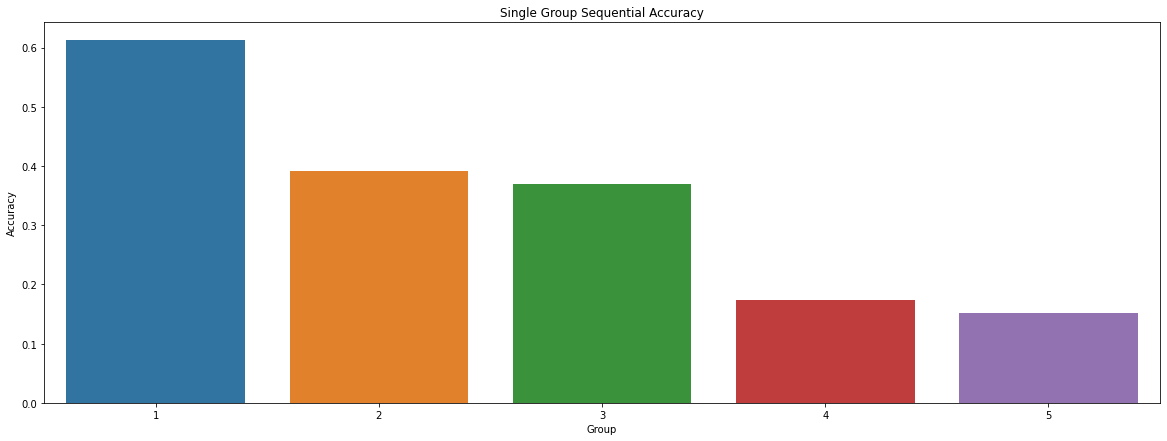

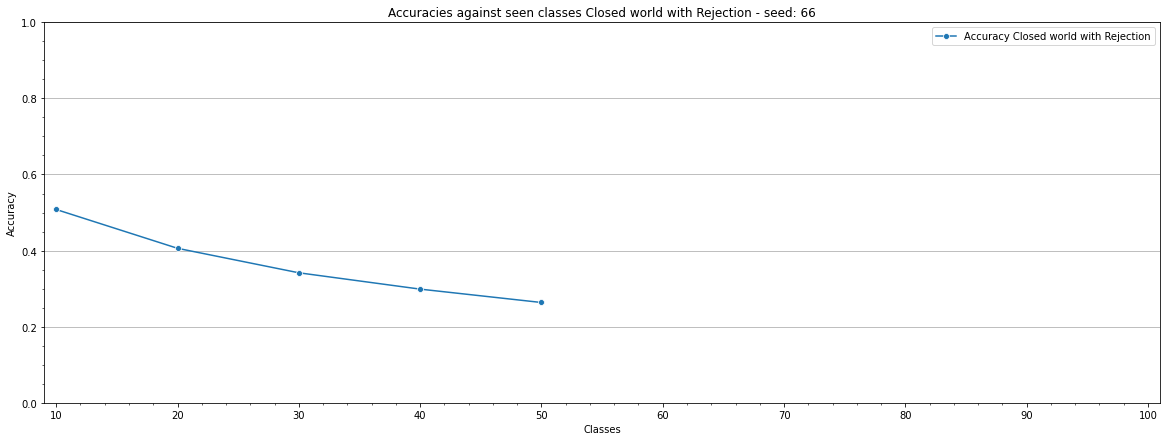

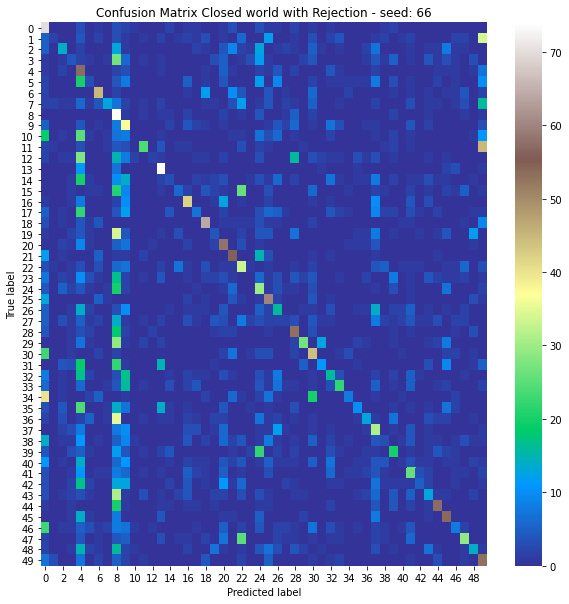

In [ ]:
method = "Closed world with Rejection"
print("metrics ClosedWord for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,5):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
 #writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

In [ ]:
closed_with_rej_acc = new_accuracies
print(closed_with_rej_acc)

[0.508, 0.406, 0.3416666666666667, 0.29875, 0.2636]


### open world with rejection

In [ ]:
def sequentialLearningiCaRLOpen(train_subsets, val_subsets, open_dataset, rejection = False, closed = True):
    net, criterion, optimizer, scheduler = getResNet32()
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 5
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset in zip(train_subsets, val_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      print("BATCH SIZE: ", BATCH_SIZE )
      print("TRAIN: ", len(train_subset))
      old_net = copy.deepcopy(net)
      old_net.to(DEVICE)
      addOutputs(net,10)
    
    
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen, rejection=rejection, closed=closed) # Train the network with 10 classes at a time

      # Validate on current group
      
      # val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      # acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen, rejection=rejection, closed=closed)
      # print("EVALUATION: ",acc, loss)

      if(group_id ==5):
        """ modify batch size for the variation """
        num_classes_seen=100
        test_loader = DataLoader(open_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=False)
        acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen, exemplars_set_tot, rejection, closed)
        all_accuracies.append(acc_all)
        print("TEST ALL: ",acc_all)
      group_id+=1

    return net, all_accuracies, all_preds_cm, all_labels_cm

In [ ]:
import gc

def validate(net, val_dataloader, criterion, num_classes, exemplar_set, rejection = False, closed = False):
    #counter for rejection part, known and unknown
    rejection = True
    if rejection==True:
      n_sample_known = 0
      n_sample_unknown = 0
    net.eval()
    exemplars_subset = []
    exemplar_loader = None 

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []
    print(len(val_dataloader))
    running_corrects = 0
    running_loss = 0.0
    for _, image, labels in val_dataloader:
        print('ciclo immagini')
        # Bring images and labels to GPU
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(image)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * image.size(0)
            
        _, preds = torch.max(outputs.data, 1)

       
        if rejection == True:
          print('1')
          #passare exemplar_set_tot
          reject = True
          feature = net.forward(image)
          # 128 * 64
          #print(feature.shape)
          mean_image = []
          cos = nn.CosineSimilarity(dim=1, eps=1e-6)
          for k, exemplar_set_class_k in exemplar_set.items():
            distances = []
          # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
            if (exemplar_set_class_k != []):
              exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
              exemplar_loader = torch.utils.data.DataLoader(exemplars_subset, shuffle = True, batch_size=1, num_workers=2)
            dist = 0
            # 40 volte
            for _, exemplars, labels  in exemplar_loader:
              # print('exemplar: ', exemplar)
              exemplars = exemplars.to(DEVICE)  
              feature_exemplar = net.forward(exemplars)
              del exemplars #delete unnecessary variables 
              gc.collect()  
              #print(feature_exemplar.shape) #1 * 64
              output = (cos(feature_exemplar, feature)) # ex1 128distanze 
              output = output.detach().cpu().numpy() #128x1
              distances.append(output) # 128x40 
            #print('DISTANZE: ', distances) # 128x40
            # 128 * 40 media orizzontale per ottenere 128x1
            mean = np.mean(distances, axis = 0) # 128x1
            mean_image.append(mean)
          print("mean_image (128x50): ", mean_image) #128x50 
          normalized_vector = ( mean_image- np.mean(mean_image, axis = 0) ) / np.std(mean_image, axis = 0)
          #print(normalized_vector)
          
          for value in normalized_vector:
            if (value < 0.5):
              reject = False
          if (reject == False):
            n_sample_known += 1
          else:
            n_sample_unknown += 1
        # if rejection == True:
        #   prediction_batch = outputs.data.cpu().numpy()
        #   print("OUTPUTS shape: ", outputs.data.shape)
        #   print("LEN PRED BATCH:", len(prediction_batch))
        #   for i in range(len(prediction_batch)):
        #     current_softmax = softmax(prediction_batch[i])
        #     #print(max(current_softmax))
        #     if max(current_softmax)>THRESHOLD:
        #       n_sample_known += 1
        #     else:
        #       n_sample_unknown += 1
        else:
          #_, preds = classify(images, )
          running_corrects += torch.sum(preds == labels.data).data.item()

          all_preds_cm.extend(preds.tolist())
          all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    if rejection == True:
      if closed == True:
        acc = n_sample_known / float(len(val_dataloader.dataset))
      else:
        acc = n_sample_unknown / float(len(val_dataloader.dataset))
    else:
      acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes, exemplar_set, rejection = False, closed = True):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes, exemplar_set, rejection, closed)
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes, exemplar_set, rejection, closed)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

In [ ]:
#open with rejection
rejection = True
closed = False
# train
net, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRLOpen(train_subsets, val_subsets, open_test, rejection=rejection, closed=closed)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


BATCH SIZE:  128
TRAIN:  4950
TRAIN_SET CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
VALIDATION CLASSES:  [59, 56, 49, 39, 22, 20, 18, 4, 67, 65]
GROUP:  1
Starting the update representation
NEW CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
Len TOTAL train susbset:  4950
training
num classes till now:  10
1
Starting epoch 1/1, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.7201578617095947
Train step - Step 10, Loss 0.30925440788269043
Train step - Step 20, Loss 0.2873806059360504
Train step - Step 30, Loss 0.2768387496471405
Train epoch - Accuracy: 0.8547474747474747 Loss: 0.3545821268510337 Corrects: 4231
Training finished in 5.665836334228516 seconds
reducing exemplars for each class
[67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
class train:  <torch.utils.data.dataset.Subset object at 0x7fb3259533d0>
Constructing exemplars of class 67
lunghezza exemplar set:  200
exemplar set:  [18314, 47266, 42180, 23457, 40782, 49153, 26453, 25145, 1973, 7786, 12437, 35749, 26910, 27071, 23517, 11435, 26294, 15628, 42128, 13341, 6455, 6380, 27043, 6928, 33169, 45433, 46666, 25966, 9653, 36708, 426, 965, 37255, 23633, 27948, 32541, 41907, 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.5417094230651855
Train step - Step 10, Loss 0.23697905242443085
Train step - Step 20, Loss 0.2361215204000473
Train step - Step 30, Loss 0.2317582666873932
Train step - Step 40, Loss 0.22931471467018127
Train step - Step 50, Loss 0.21129079163074493
Train epoch - Accuracy: 0.9031654676258993 Loss: 0.2589032570663974 Corrects: 6277
Training finished in 13.2768235206604 seconds
reducing exemplars for each class
[67, 59, 39, 22, 18, 65, 49, 56, 20, 4, 79, 47, 7, 82, 34, 81, 21, 80, 68, 16]
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  100
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
REDUCED EXEMPLAR:  0
class train:  <torch.utils.data.dataset.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.3794572949409485
Train step - Step 10, Loss 0.21821501851081848
Train step - Step 20, Loss 0.21837572753429413
Train step - Step 30, Loss 0.21101343631744385
Train step - Step 40, Loss 0.20947399735450745
Train step - Step 50, Loss 0.20467664301395416
Train epoch - Accuracy: 0.9440287769784173 Loss: 0.23036658257031611 Corrects: 6561
Training finished in 13.362017631530762 seconds
reducing exemplars for each class
[67, 59, 39, 22, 18, 65, 49, 56, 20, 4, 79, 47, 7, 82, 34, 81, 21, 80, 68, 16, 75, 23, 90, 10, 61, 76, 64, 32, 24, 0]
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR:  66
REDUCED EXEMPLAR: 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.3489232659339905
Train step - Step 10, Loss 0.22502465546131134
Train step - Step 20, Loss 0.2071315050125122
Train step - Step 30, Loss 0.2082352638244629
Train step - Step 40, Loss 0.1994708776473999
Train step - Step 50, Loss 0.20731286704540253
Train epoch - Accuracy: 0.9577200577200577 Loss: 0.22288345802483964 Corrects: 6637
Training finished in 13.385721921920776 seconds
reducing exemplars for each class
[67, 59, 39, 22, 18, 65, 49, 56, 20, 4, 79, 47, 7, 82, 34, 81, 21, 80, 68, 16, 75, 23, 90, 10, 61, 76, 64, 32, 24, 0, 95, 83, 63, 42, 30, 6, 2, 97, 72, 36]
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUCED EXEMPLAR:  50
REDUC

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.3376277983188629
Train step - Step 10, Loss 0.229234978556633
Train step - Step 20, Loss 0.21059942245483398
Train step - Step 30, Loss 0.21688327193260193
Train step - Step 40, Loss 0.20810475945472717
Train step - Step 50, Loss 0.20898741483688354
Train epoch - Accuracy: 0.9784172661870504 Loss: 0.22357994300427197 Corrects: 6800
Training finished in 13.44616174697876 seconds
reducing exemplars for each class
[67, 59, 39, 22, 18, 65, 49, 56, 20, 4, 79, 47, 7, 82, 34, 81, 21, 80, 68, 16, 75, 23, 90, 10, 61, 76, 64, 32, 24, 0, 95, 83, 63, 42, 30, 6, 2, 97, 72, 36, 55, 31, 19, 98, 94, 54, 93, 85, 9, 96]
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EXEMPLAR:  40
REDUCED EX

## Variation

### Data Augmentation


*   **brightness**: the intensity of the original image is altered by adding a random intensity value in the range [-63,63]
*   **contrast normalization**: the contrast of the original image is altered by a random value in the range [0.2,1.8]
*   **random cropping**: all the images (original, brightness and costrast) are randomly cropped
*   **mirroring**: a mirror image is computed for all images (original, brightness, contrast and crops)


HOW TO USE

    for _, images, labels in train_dataloader: 
  
        """  
        perform data augmentation 
        """ 
        # print("Dimension before data augmentation: ", images.shape) 
        # print("...performing data augmentation...") 
        images, labels = data_augmentation_e2e(images,labels) 
  
        # print("Dimension after data augmentation: ", images.shape) 
  
  
        images = torch.from_numpy(images) 
        labels = torch.from_numpy(labels) 
  
  
  
        # Bring images and labels to GPU 
        images = images.to(DEVICE,dtype=torch.float32) 
        labels = labels.to(DEVICE,dtype=torch.float32)

In [ ]:
import tensorflow as tf
def data_augmentation_e2e(img, lab):
    """
        Realize the data augmentation in End-to-End paper
        Parameters
        ----------
        img: the original images, size = (n, c, w, h)
        lab: the original labels, size = (n)
        Returns
        ----------
        img_aug: the original images, size = (n * 12, c, w, h)
        lab_aug: the original labels, size = (n * 12)
    """
    
    shape = np.shape(img)
    # print("IMG is: ",img)
    # print(shape[0], 1, shape[1], shape[2], shape[3])
    img_aug = np.zeros((shape[0], 6, shape[1], shape[2], shape[3]))
    img_aug[:, 0, :, :, :] = img
    lab_aug = np.zeros((shape[0], 6))
    # print("IMG_AUG is: ", img_aug)

    for i in range(shape[0]):
        # np.random.seed(int(time.time()) % 1000)

        # convert image from tensor to numpy
        image=img.numpy()
        im = image[i]
      
        # # brightness
        brightness = (np.random.rand(1)-0.5)*2*63
        im_temp = im + brightness

        img_aug[i, 1] = im_temp


        # constrast
        constrast = (np.random.rand(1)-0.5)*2*0.8+1
        m0 = np.mean(im[0])
        m1 = np.mean(im[1])
        m2 = np.mean(im[2])
        im_temp = im
        im_temp[0] = (im_temp[0]-m0)*constrast + m0
        im_temp[1] = (im_temp[1]-m1)*constrast + m1
        im_temp[2] = (im_temp[2]-m2)*constrast + m2
        img_aug[i, 2] = im_temp

        # crop
        im_temp = img_aug[i, :3]
        for j in range(3):
            x_ = int(np.random.rand(1)*1000)%8
            y_ = int(np.random.rand(1)*1000)%8
            im_temp = np.zeros(shape=(shape[1], shape[2]+8, shape[3]+8))
            im_temp[:, 4:-4, 4:-4] = img_aug[i, j]
            img_aug[i, 3+j] = im_temp[:, x_:x_+shape[2], y_:y_+shape[3]]



        # mirror
        # for j in range(6):
        #     im_temp = img_aug[i, j]
        #     img_aug[i, 6 + j] = im_temp[:,-1::-1,:]

        lab_aug[i, :] = lab[i]

    # idx = np.where(img_aug>255)
    # img_aug[idx] = 255
    # idx = np.where(img_aug<0)
    # img_aug[idx] = 0

    img_aug = np.reshape(img_aug, newshape=(shape[0]*6, shape[1], shape[2], shape[3]))
    img_aug = np.array(img_aug, dtype=np.float64)
    lab_aug = np.reshape(lab_aug, newshape=(shape[0]*6))
    lab_aug = np.array(lab_aug, dtype=np.float64)
    return img_aug, lab_aug

### prova

In [ ]:
train_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4, drop_last=False)
n = 1
i = 0
for _, images, labels in train_loader:
  if i == 0:
    print(images.shape, labels.shape)
    print(images, labels)
    images_combined, labels_combined = data_augmentation_e2e(images,labels)
    print(images_combined.shape, labels_combined.shape)
    print(images_combined, labels_combined)
    i = 2
  else:
    break
  

In [ ]:
import torch
import torch.nn as nn
input1 = torch.randn(100,64)
print(input1.shape)
input2 = torch.randn(1,64)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)
print(output.shape)



torch.Size([100, 64])
torch.Size([100])
